### Import lib

In [84]:
import os
os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from treeconfigparser import TreeConfigParser
import joblib

import models.reg as rg 
from data.Data import Data

## Download func

In [72]:
path_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"

In [129]:
def get_data_for_reg(ds: str, scaler):
    config = TreeConfigParser()
    config.readfiles(os.path.join(path_res, ds, "config.cfg"))
    shuffle_indices = np.fromfile(os.path.join(path_res, ds, "shuffle_indices.bin")).astype(np.int64)
    data = Data(config, shuffle_indices)
    data.prepare_input(scaler)
    data.prepare_output()
    print("xco2 valid mean", np.mean(data.y.valid[0]))
    return data

In [160]:
scaler = get_scaler('/cerea_raid/users/dumontj/dev/coco2/dl/res/reg_pw')

In [172]:
config = TreeConfigParser()
config.readfiles(os.path.join(path_res, 'reg_par', "config.cfg"))
shuffle_indices = np.fromfile(os.path.join(path_res, 'reg_par', "shuffle_indices.bin")).astype(np.int64)
data_1 = Data(config, shuffle_indices)
data_1.prepare_input(scaler)

407.1401 6.244527
data.inp.train.shape[0] (3571, 160, 160, 3)


In [169]:
data_2 = Data(config, shuffle_indices)
data_2.prepare_input()

407.1401
data.inp.train.shape[0] (3571, 160, 160, 3)


In [163]:
data_3 = Data(config, shuffle_indices)
data_3.prepare_input()

data.inp.train.shape[0] (3571, 160, 160, 3)


In [171]:
config = TreeConfigParser()
config.readfiles(os.path.join(path_res, 'reg_pw', "config.cfg"))
shuffle_indices = np.fromfile(os.path.join(path_res, 'reg_pw', "shuffle_indices.bin")).astype(np.int64)
data_4 = Data(config, shuffle_indices)
data_4.prepare_input(scaler)

402.15048 11.6537075
data.inp.train.shape[0] (13748, 160, 160, 3)


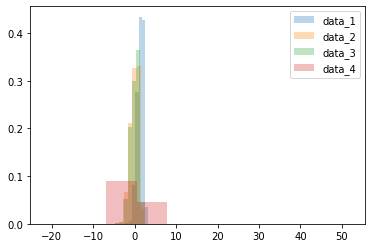

In [170]:
plt.hist(data_1.x.train[0].flatten(), label="data_1", alpha=0.3, density=True)
plt.hist(data_2.x.train[0].flatten(), label="data_2", alpha=0.3, density=True)
plt.hist(data_3.x.train[0].flatten(), label="data_3", alpha=0.3, density=True)
plt.hist(data_4.x.train[0].flatten(), label="data_4", alpha=0.3, density=True)
plt.legend()

In [3]:
def get_reg_model(path_w: str, choice="best"):
    if choice == "best":
        print (os.path.join(path_w, "weights_cp_best.h5"))
        model = keras.models.load_model(os.path.join(path_w, "weights_cp_best.h5"), compile=True)
    elif choice == "last":
        model = keras.models.load_model(os.path.join(path_w, "weights_model.h5"), compile=True)    
    return model

def get_scaler(path_w: str):
    scaler = joblib.load(os.path.join(path_w, "scaler.save"))
    return scaler

In [4]:
def eval_ds_with_model(data, model):
    x_valid = tf.convert_to_tensor(data.x.valid[0], np.float32)
    y_valid = tf.convert_to_tensor(data.y.valid, np.float32)
    loss_valid = model.evaluate(x=x_valid, y=y_valid, batch_size=64)
    return loss_valid

In [112]:
def eval_ds_with_baseline(data, model):
    y_train = tf.convert_to_tensor(data.y.train, np.float32)
    mean_train = tf.math.reduce_mean(y_train) * tf.ones_like(y_train, np.float32)
    print(mean_train)
    loss_baseline = model.compute_loss(y=y_train, y_pred=mean_train).numpy()
    return loss_baseline

## Make df of results

### Case choices

In [74]:
names_ds = ["par", "ber", "pw"]
df_indices_ds = ["ds_" + case for case in names_ds]
keys_ds = ["reg_" + case for case in names_ds]

names_w = ["par", "ber", "pw", "ber_DA"]
df_indices_w = ["w_" + case for case in names_w]
keys_w = ["reg_" + case for case in names_w]

In [121]:
df = pd.DataFrame(dict(zip(df_indices_w, [[-1.]*len(names_ds)]*len(names_w))))
df.index = index_ds
for df_idx_w, key_w in zip(df_indices_w, keys_w):
    full_path_w = os.path.join("/cerea_raid/users/dumontj/dev/coco2/dl/res", key_w)
    model = get_reg_model(full_path_w)
    scaler = get_scaler(full_path_w)
    for df_idx_ds, key_ds in zip(df_indices_ds, keys_ds):
        data = get_data_for_reg(key_ds, scaler)
        loss_valid = eval_ds_with_model(data, model)
        df.loc[df_idx_ds, df_idx_w] = loss_valid  

/cerea_raid/users/dumontj/dev/coco2/dl/res/reg_par/weights_cp_best.h5


KeyboardInterrupt: 

In [ ]:
df

#### Add baseline

In [115]:
df["mean_bl"] = [-1.]*len(df.index)
for df_idx_ds, key_ds in zip(df_indices_ds, keys_ds):
    config_file = os.path.join("/cerea_raid/users/dumontj/dev/coco2/dl/cfg", key_ds + ".cfg")
    config = TreeConfigParser()
    config.readfiles(config_file)
    data = Data(config)
    data.prepare_output()
    
    mean_bl = eval_ds_with_baseline(data, model)
    df.loc[df_idx_ds, "mean_bl"] = mean_bl

data.out.train.shape (3571, 1)
tf.Tensor(
[[29.58639]
 [29.58639]
 [29.58639]
 ...
 [29.58639]
 [29.58639]
 [29.58639]], shape=(3571, 1), dtype=float32)
data.out.train.shape (6874, 1)
tf.Tensor(
[[16.789188]
 [16.789188]
 [16.789188]
 ...
 [16.789188]
 [16.789188]
 [16.789188]], shape=(6874, 1), dtype=float32)
data.out.train.shape (13748, 1)
tf.Tensor(
[[24.294043]
 [24.294043]
 [24.294043]
 ...
 [24.294043]
 [24.294043]
 [24.294043]], shape=(13748, 1), dtype=float32)


In [116]:
df

,w_par,w_ber,w_pw,w_ber_DA,mean_bl
ds_par,0.312819,0.623243,0.437430,0.542043,0.345988
ds_ber,0.585111,0.164860,0.182699,0.144525,0.182187
ds_pw,0.598102,0.317817,0.045991,0.283893,0.199250
